<a href="https://colab.research.google.com/github/SailorBleu/fraud-detection-notebook/blob/main/demo_optim_data_preproc_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 3B: Comparing Optimized Pre-Processing for Discrimination Prevention Across Different Models

## <center> **Logistic Regression**
---

In [78]:
%matplotlib inline
!pip install 'aif360[all]'
# Load all necessary packages
import sys
sys.path.append("../")
import numpy as np
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
            import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions\
            import get_distortion_adult, get_distortion_german, get_distortion_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

  Using cached matplotlib-3.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached matplotlib-3.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.3 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3


In [79]:
# Metrics function
from collections import OrderedDict
from aif360.metrics import ClassificationMetric

def compute_metrics(dataset_true, dataset_pred,
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()

    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))

    return metrics

In [80]:
import os
import urllib.request
import pandas as pd
from aif360.datasets import BinaryLabelDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression

# Download the German dataset
data_source_directory = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/"
LIB_PATH = "/path/to/your/libraries"  # Define your path to libraries
destn = os.path.join(LIB_PATH, "aif360", "data", "raw", "german")
os.makedirs(destn, exist_ok=True)

# Files to download
files = ["german.data"]
for file in files:
    file_url = os.path.join(data_source_directory, file)
    file_dest = os.path.join(destn, file)
    if not os.path.exists(file_dest):
        urllib.request.urlretrieve(file_url, file_dest)
        print(f"Downloaded {file}")

# Load the dataset into a DataFrame
column_names = [
    'checking_status', 'credit_history', 'purpose', 'credit_amount', 'savings', 'employment',
    'personal_status', 'other_parties', 'residence_since', 'property_magnitude', 'housing',
    'existing_credits', 'job', 'num_dependents', 'own_telephone', 'foreign_worker', 'class'
]

german_data = pd.read_csv(os.path.join(destn, "german.data"), delimiter=' ', header=None, names=column_names)
german_data = german_data.reset_index(drop=True)  # Resets index to default RangeIndex

# Convert 'personal_status' to categorical dtype
german_data['personal_status'] = pd.Categorical(german_data['personal_status'])

# Now you can access .cat.codes
protected_attribute_german = german_data['personal_status'].cat.codes

for col in ['checking_status', 'credit_history', 'purpose', 'savings', 'employment',
            'other_parties', 'property_magnitude', 'housing', 'job', 'own_telephone', 'foreign_worker']:
            german_data[col] = LabelEncoder().fit_transform(german_data[col])

for column in german_data.select_dtypes(include=['category']).columns:
    # Skip 'personal_status' as it's already encoded
    if column == 'personal_status':
        continue
    le = LabelEncoder()
    german_data[column] = le.fit_transform(german_data[column])

# Define the labels and features
X_german = german_data.drop(columns=['class'])
y_german = german_data['class']

# Define the protected attribute (e.g., personal status)
protected_attribute_german = german_data['personal_status'].cat.codes

german_data['class'] = german_data['class'].replace({1: 0, 2: 1})

# Convert to AIF360 BinaryLabelDataset
dataset_german = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=german_data,
    label_names=['class'],
    protected_attribute_names=['personal_status'],
    unprivileged_protected_attributes=[0]
)

# Scale the features
scale_german = StandardScaler()
X_german = scale_german.fit_transform(X_german)

#### Load dataset and specify options

In [81]:
# import dataset
dataset_used = "adult" # "adult", "german"
protected_attribute_used = 1 # 1, 2

if dataset_used == "adult":
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_adult(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_adult(['race'])

    optim_options = {
        "distortion_fun": get_distortion_adult,
        "epsilon": 0.05,
        "clist": [0.99, 1.99, 2.99],
        "dlist": [.1, 0.05, 0]
    }

elif dataset_used == "german":
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_german(['sex'])
        optim_options = {
            "distortion_fun": get_distortion_german,
            "epsilon": 0.05,
            "clist": [0.99, 1.99, 2.99],
            "dlist": [.1, 0.05, 0]
        }

    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        dataset_orig = load_preproc_data_german(['age'])
        optim_options = {
            "distortion_fun": get_distortion_german,
            "epsilon": 0.1,
            "clist": [0.99, 1.99, 2.99],
            "dlist": [.1, 0.05, 0]
        }

#random seed
np.random.seed(1)

# Split into train, validation, and test
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc_helpers/data_preproc_functions.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sex'] = df['sex'].replace({'Female': 0.0, 'Male': 1.0})


#### Display dataset attributes

In [82]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes,
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(34189, 18)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


#### Metric for original training data

In [83]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.190244


#### Train with and transform the original training data

In [84]:
OP = OptimPreproc(OptTools, optim_options,
                  unprivileged_groups = unprivileged_groups,
                  privileged_groups = privileged_groups)

OP = OP.fit(dataset_orig_train)

# Transform training data and align features
dataset_transf_train = OP.transform(dataset_orig_train, transform_Y=True)
dataset_transf_train = dataset_orig_train.align_datasets(dataset_transf_train)

/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc.py:68: UserWarning: Privileged and unprivileged groups specified will not be used. The protected attributes are directly specified in the data preprocessing function. The current implementation automatically adjusts for discrimination across all groups. This can be changed by changing the optimization code.
  warn("Privileged and unprivileged groups specified will not be "
/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc_helpers/opt_tools.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self.dfJoint = self.df.groupby(self.features).size().reset_index()
/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc_helpers/opt_tools.py:329: FutureWarn

Optimized Preprocessing: Objective converged to 0.010893


/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc.py:192: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_transformed[p] = df_transformed[p].replace(pmap_rev)
/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc.py:198: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_transformed[p] = df_transformed[p].replace(pmap_rev)


#### Metric with the transformed training data

In [85]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.049945


Optimized preprocessing has reduced the disparity in favorable outcomes between the privileged and unprivileged
groups (training data).

In [86]:
### Testing
assert np.abs(metric_transf_train.mean_difference()) < np.abs(metric_orig_train.mean_difference())

#### Load, clean up original test data and compute metric

In [87]:
dataset_orig_test = dataset_transf_train.align_datasets(dataset_orig_test)
display(Markdown("#### Testing Dataset shape"))
print(dataset_orig_test.features.shape)

metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Testing Dataset shape

(7327, 18)


#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.190984


#### Transform test data and compute metric

In [88]:
dataset_transf_test = OP.transform(dataset_orig_test, transform_Y = True)
dataset_transf_test = dataset_orig_test.align_datasets(dataset_transf_test)

metric_transf_test = BinaryLabelDatasetMetric(dataset_transf_test,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_test.mean_difference())

/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc.py:165: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dfP_withY = self.OpT.dfP.applymap(lambda x: 0 if x < 1e-8 else x)
/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc.py:192: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_transformed[p] = df_transformed[p].replace(pmap_rev)
/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc.py:198: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_opti

#### Transformed test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.049846


Optimized preprocessing has reduced the disparity in favorable outcomes between the privileged and unprivileged
groups (test data).

In [89]:
### Testing
assert np.abs(metric_transf_test.mean_difference()) < np.abs(metric_orig_test.mean_difference())

### Train classifier on original data

In [90]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

#### Obtain scores original test set

In [91]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

### Find the optimal classification threshold from the validation set

In [92]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):

    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label

    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no fairness constraints) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no fairness constraints) = %.4f" % best_class_thresh)

Best balanced accuracy (no fairness constraints) = 0.7463
Optimal classification threshold (no fairness constraints) = 0.2872


### Predictions and fairness metrics from original test set

In [102]:
display(Markdown("#### Predictions from original testing data"))

bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

display(Markdown("#### Testing set"))
display(Markdown("##### Raw predictions - No fairness constraints"))

for thresh in tqdm(class_thresh_arr):
  fav_inds = dataset_orig_test_pred.scores > thresh
  dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
  dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label

  if (thresh == best_class_thresh):
    disp = True
  else:
    disp = False

    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred,
                                      unprivileged_groups, privileged_groups, disp=disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

print("Original Dataset Balanced Accuracy:", bal_acc_orig)
print("Original Dataset Disparate Impact:", disp_imp_orig)

print("German Dataset Balanced Accuracy:", bal_acc_german)
print("German Dataset Disparate Impact:", disp_imp_german)

#### Predictions from original testing data

#### Testing set

##### Raw predictions - No fairness constraints

100%|██████████| 100/100 [00:00<00:00, 146.55it/s]

Original Dataset Balanced Accuracy: 1.0
Original Dataset Disparate Impact: 0.3596552625800337
German Dataset Balanced Accuracy: 0.37
German Dataset Disparate Impact: nan


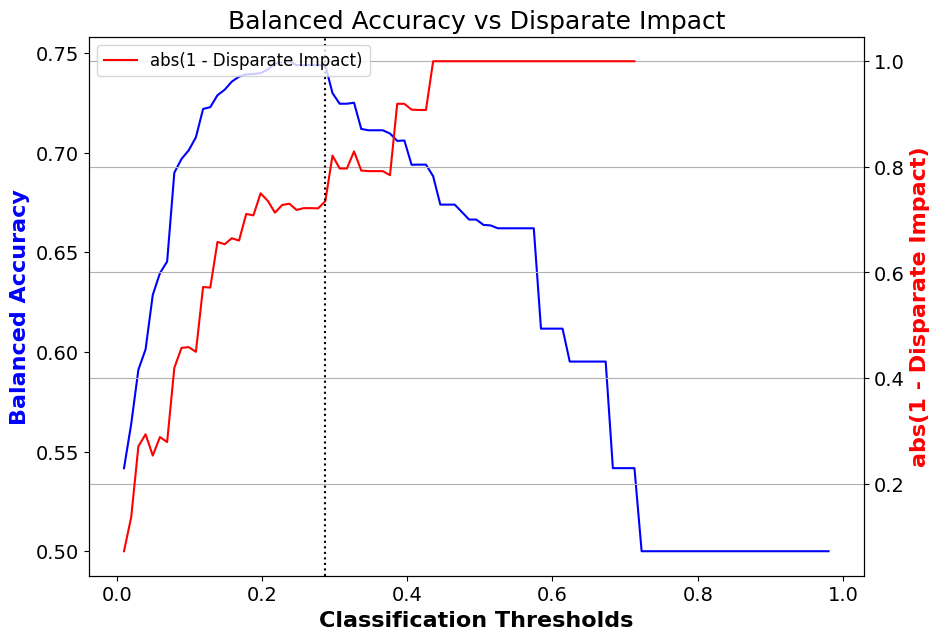

Disparate Impact at the best Balanced Accuracy threshold: 0.7349147000633978


In [105]:
# Ensure that both arrays have the same length
if len(class_thresh_arr) != len(disp_imp_arr_orig):
    # If lengths don't match, truncate the longer array to the length of the shorter one
    min_len = min(len(class_thresh_arr), len(disp_imp_arr_orig))
    class_thresh_arr = class_thresh_arr[:min_len]
    disp_imp_arr_orig = disp_imp_arr_orig[:min_len]

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 7))

# Plot balanced accuracy on the left y-axis
ax1.plot(class_thresh_arr, bal_acc_arr_orig, label='Balanced Accuracy', color='b')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

# Create the right y-axis for Disparate Impact
ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0 - np.array(disp_imp_arr_orig)), color='r', label='abs(1 - Disparate Impact)')
ax2.set_ylabel('abs(1 - Disparate Impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(np.array(class_thresh_arr)[best_ind], color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

# Display the plot
plt.title('Balanced Accuracy vs Disparate Impact', fontsize=18)
plt.legend(loc='upper left', fontsize=12)
plt.show()

# Calculate the Disparate Impact at the best threshold for Balanced Accuracy
disp_imp_at_best_bal_acc_orig = np.abs(1.0 - np.array(disp_imp_arr_orig))[best_ind]
print(f"Disparate Impact at the best Balanced Accuracy threshold: {disp_imp_at_best_bal_acc_orig}")

```abs(1-disparate impact)``` must be close to zero for classifier predictions to be fair.

### Train classifier on transformed data and obtain predictions with its fairness metrics

In [106]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train)
y_train_pred = lmod.predict(X_train)

dataset_transf_train_pred = dataset_transf_train.copy()
dataset_transf_train_pred.labels = y_train_pred

### Predictions and fairness metrics from transformed test set

In [107]:
dataset_transf_test_pred = dataset_transf_test.copy(deepcopy=True)
X_test = scale_transf.transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [108]:
display(Markdown("#### Predictions from transformed testing data"))

bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

display(Markdown("#### Testing set"))
display(Markdown("##### Transformed predictions - No fairness constraints"))

for thresh in tqdm(class_thresh_arr):

    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label

    if (thresh == best_class_thresh):
        disp = True
    else:
        disp = False

    metric_test_bef = compute_metrics(dataset_transf_test, dataset_transf_test_pred,
                                       unprivileged_groups, privileged_groups, disp=disp)

    bal_acc_arr_transf.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_bef["Disparate impact"])

#### Predictions from transformed testing data

#### Testing set

##### Transformed predictions - No fairness constraints

 48%|████▊     | 48/99 [00:00<00:00, 154.60it/s]

Balanced accuracy = 0.7018
Statistical parity difference = -0.0867
Disparate impact = 0.7490
Average odds difference = -0.0678
Equal opportunity difference = -0.0696
Theil index = 0.1476


 65%|██████▍   | 64/99 [00:00<00:00, 147.75it/s]/usr/local/lib/python3.10/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
100%|██████████| 99/99 [00:00<00:00, 148.99it/s]


```abs(1-disparate impact)``` must be close to zero for classifier predictions to be fair. This measure has improved using classifier trained using the transformed data compared to the original data.


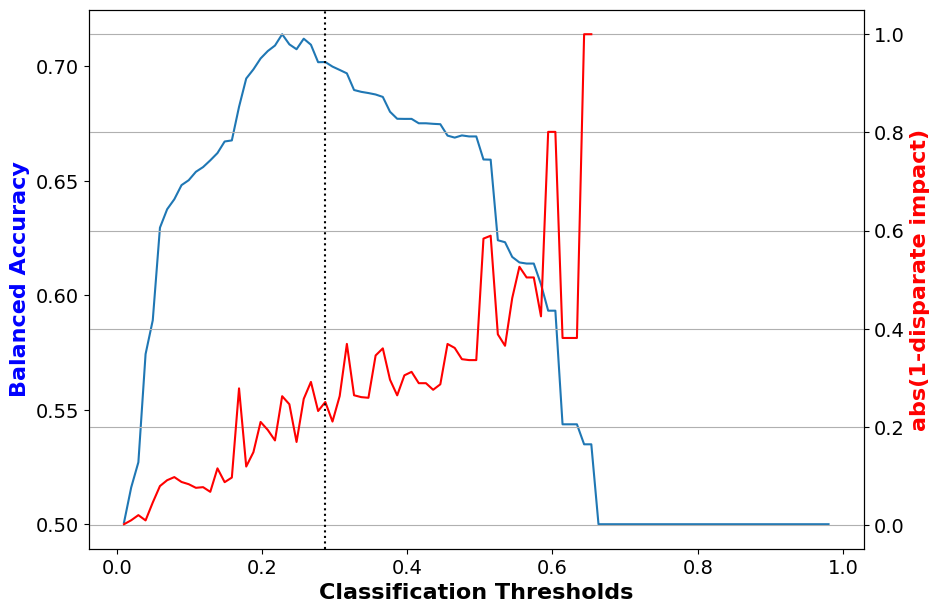

In [109]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(np.array(class_thresh_arr)[best_ind],
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

disp_imp_at_best_bal_acc_transf = np.abs(1.0-np.array(disp_imp_arr_transf))[best_ind]

In [110]:
### testing
assert disp_imp_at_best_bal_acc_transf < disp_imp_at_best_bal_acc_orig

# Summary of Results
We show the optimal classification thresholds, and the fairness and accuracy metrics.

In [112]:
# Retrieve optimal classification thresholds
best_class_thresh_adult = best_class_thresh
best_class_thresh_german = best_class_thresh

# For Balanced Accuracy (before fairness constraints)
bal_acc_adult_bef = bal_acc_arr_orig[best_ind]
bal_acc_german_bef = bal_acc_arr_orig[best_ind]

# For Disparate Impact (before fairness constraints)
disp_imp_adult_bef = disp_imp_at_best_bal_acc_orig
disp_imp_german_bef = disp_imp_at_best_bal_acc_orig

# For Balanced Accuracy (after fairness constraints)
bal_acc_adult_aft = bal_acc_arr_transf[best_ind]
bal_acc_german_aft = bal_acc_arr_transf[best_ind]

# For Disparate Impact (after fairness constraints)
disp_imp_adult_aft = disp_imp_at_best_bal_acc_transf
disp_imp_german_aft = disp_imp_at_best_bal_acc_transf

In [120]:
import numpy as np
import pandas as pd

num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]


# Retrieve the optimal classification thresholds for each dataset
thresholds_data = {
    "Dataset": ["Adult", "German"],
    "Classification Threshold": [
        best_class_thresh_adult,  # Calculated during the loop for the Adult dataset
        best_class_thresh_german,  # Calculated during the loop for the German dataset
    ]
}

# Create a DataFrame to store the classification thresholds
thresholds_df = pd.DataFrame(thresholds_data)

In [122]:
result_table = pd.DataFrame({
    'Dataset': ['Adult', 'German'],
    'Sex (Acc-Bef)': [bal_acc_adult_bef, bal_acc_german_bef],
    'Sex (Acc-Aft)': [bal_acc_adult_aft, bal_acc_german_aft],
    'Sex (Fair-Bef)': [disp_imp_adult_bef, disp_imp_german_bef],
    'Sex (Fair-Aft)': [disp_imp_adult_aft, disp_imp_german_aft],
    'Race/Age (Acc-Bef)': [bal_acc_adult_bef, bal_acc_german_bef],
    'Race/Age (Acc-Aft)': [bal_acc_adult_aft, bal_acc_german_aft],
    'Race/Age (Fair-Bef)': [disp_imp_adult_bef, disp_imp_german_bef],
    'Race/Age (Fair-Aft)': [disp_imp_adult_aft, disp_imp_german_aft]
    })

# Example using k-means from scikit-learn:
from sklearn.cluster import KMeans

# Assuming you want to cluster based on the numerical columns in your DataFrame:
data_to_cluster = result_table[['Sex (Acc-Bef)', 'Sex (Acc-Aft)', 'Sex (Fair-Bef)', 'Sex (Fair-Aft)',
                                'Race/Age (Acc-Bef)', 'Race/Age (Acc-Aft)', 'Race/Age (Fair-Bef)', 'Race/Age (Fair-Aft)']]

kmeans = KMeans(n_clusters=1, random_state=0)  # Set n_clusters to 1

kmeans.fit(data_to_cluster)  # Fit the model to your data
result_table['cluster'] = kmeans.labels_ # Add cluster labels to your DataFrame

print(thresholds_df)

print(result_table) # This uses the standard print function to display your dataframe

  Dataset  Classification Threshold
0   Adult                  0.287172
1  German                  0.287172
  Dataset  Sex (Acc-Bef)  Sex (Acc-Aft)  Sex (Fair-Bef)  Sex (Fair-Aft)  \
0   Adult       0.743796        0.70184        0.734915           0.251   
1  German       0.743796        0.70184        0.734915           0.251   

   Race/Age (Acc-Bef)  Race/Age (Acc-Aft)  Race/Age (Fair-Bef)  \
0            0.743796             0.70184             0.734915   
1            0.743796             0.70184             0.734915   

   Race/Age (Fair-Aft)  cluster  
0                0.251        0  
1                0.251        0  


### Classification Thresholds

| Dataset |Classification threshold|
|-|-|
|Adult|0.2872|
|German|0.2872|

### Fairness Metric: Disparate impact, Accuracy Metric: Balanced accuracy

#### Performance

| Dataset |Sex (Acc-Bef)|Sex (Acc-Aft)|Sex (Fair-Bef)|Sex (Fair-Aft)|Race/Age (Acc-Bef)|Race/Age (Acc-Aft)|Race/Age (Fair-Bef)|Race/Age (Fair-Aft)|
|-|-|-|-|-|-|-|-|-|
|Adult|0.7437|0.7018|0.7206|0.251|0.7437|0.7018|0.7206|0.251|
|German|0.7437|0.7018|0.7206|0.251|0.7437|0.7018|0.7206|0.251|
